<a href="https://colab.research.google.com/github/yongminkim0501/Image_deep/blob/main/IOU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/data_ai/train_buildings_image/

/content/drive/MyDrive/data_ai/train_buildings_image


In [ ]:
dataset_path = "/content/drive/MyDrive/data_ai/"
json_path = "/content/drive/MyDrive/data_ai/train_buildings_labels"
original_path = "/content/drive/MyDrive/data_ai/train_buildings_image"

In [ ]:
import json
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import cv2
import json

json_load1 = []
img1 = []

import os
dataset_path = "/content/drive/MyDrive/data_ai/"
png_list = os.listdir(json_path)

for i in range (len(png_list)):
  png_list[i] = png_list[i].split(".")

png_t = []
for i in range (len(png_list)):
  if len(png_list[i]) == 2 and png_list[i][1] == 'json':
    png_t.append(png_list[i][0])

for item in png_t:
  img = np.zeros((1024, 1024, 3), np.uint8)

  with open(json_path+f"/{item}.json") as json_file:
    json_load = json.load(json_file)
    json.dumps(json_load, indent='\t')
  for number in range(len(json_load["features"])):
    vv = json_load["features"][number]["properties"]["building_imcoords"]
    a = vv.split(", ")

    pts = []
    for i in range(0,int(len(a)/2)):
      vvv = []
      vvv.append(float(a[2*i]))
      vvv.append(float(a[2*i+1]))
      pts.append(vvv)

    for i in range(0,int(len(a)/2)):
      for j in range(2):
        pts[i][j] = int(pts[i][j])
    pts = np.array(pts)
    img = cv2.fillPoly(img, [pts],(255,255,255))
  cv2.imwrite(f'/content/drive/MyDrive/data_ai/json_images_building/{item}.png', img)

In [ ]:
import copy
import json
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import cv2
import json

json_load1 = []
img1 = []

import os
dataset_path = "/content/drive/MyDrive/data_ai/"
png_list = os.listdir(json_path)

for i in range (len(png_list)):
  png_list[i] = png_list[i].split(".")

png_t = []
for i in range (len(png_list)):
  if len(png_list[i]) == 2 and png_list[i][1] == 'json':
    png_t.append(png_list[i][0])

k = copy.deepcopy(png_t[:2000])
png_t = None

In [ ]:
import matplotlib.pyplot as plt
import cv2
label_image_black_white = []
label_origin_image = []

for name in k:

  img = cv2.imread(f"/content/drive/MyDrive/data_ai/json_images_building/{name}.png", cv2.IMREAD_GRAYSCALE)

  lab = cv2.imread(f"/content/drive/MyDrive/data_ai/train_buildings_image/{name}.png")

  if np.array(img).shape[0] != 1024 or np.array(lab).shape[0] != 1024:
    continue

  img = cv2.resize(img, (128, 128))
  lab = cv2.resize(lab, (128, 128))
  label_image_black_white.append(img)
  label_origin_image.append(lab)

In [ ]:
x_test = []
x_train = []

y_test = []
y_train = []
import os
dataset_path = "/content/drive/MyDrive/data_ai/"
# png_list = os.listdir("/content/drive/MyDrive/data_ai/train_buildings_labels/")
# for i in range (len(png_list)):
#   png_list[i] = png_list[i].split(".")
# png_t = []
# for i in range (len(png_list)):
#   if len(png_list[i]) == 2 and png_list[i][1] == 'json':
#     png_t.append(png_list[i][0])

for i in range(0, round(len(k)*0.8)):
  x_train.append(label_origin_image[i])
  y_train.append(label_image_black_white[i])

for i in range(round(len(k)*0.8), len(k)):
  x_test.append(label_origin_image[i])
  y_test.append(label_image_black_white[i])

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
def attention_gate(input_signal, gating_signal, num_filters):
    # gating_signal을 input_signal과 같은 크기로 조정
    gating_signal = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(gating_signal)

    # 1x1 convolution
    input_signal = Conv2D(num_filters, 1, padding='same')(input_signal)
    gating_signal = Conv2D(num_filters, 1, padding='same')(gating_signal)

    # 신호 결합
    added = Add()([input_signal, gating_signal])

    # 활성화
    activated = Activation('relu')(added)

    # attention 계수 계산
    attention = Conv2D(1, 1, padding='same')(activated)
    attention = Activation('sigmoid')(attention)

    # attention 적용
    return Multiply()([input_signal, attention])

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    attended_skip = attention_gate(skip_features, input, num_filters)
    # x = Concatenate()([x, skip_features])
    x = Concatenate()([x, attended_skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    size = 16     # ORiginal: 16
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, size * 4)
    s2, p2 = encoder_block(p1, size * 8)
    s3, p3 = encoder_block(p2, size * 16)
    s4, p4 = encoder_block(p3, size * 32)

    b1 = conv_block(p4, size * 64)    # Original is 1024

    d1 = decoder_block(b1, s4, size * 32)
    d2 = decoder_block(d1, s3, size * 16)
    d3 = decoder_block(d2, s2, size * 8)
    d4 = decoder_block(d3, s1, size * 4)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
'''
tf.keras.layers.Conv2D(
    filters, : 출력 채널의 수, filters = 32 이면, 32개의 특성 맵 생성
    kernel_size, : 컨볼루션 윈도의 크기, kernel size=3 : 3x3 필터
    strides=(1, 1), : 필터가 이동하는 간격
    padding='valid', : valid - 패딩 없음, same : 출력 크기와 입력 크기 동일하도록 패딩
    data_format=None, :
    dilation_rate=(1, 1), : 팽창된 컨볼루션을 위한 팽창률, (1,1) - 일반 컨볼루션, (2,2) - 필터 원소 사이에 공간 추가
    groups=1, : 입력과 출력 채널을 그룹으로 나누는 수, 1은 일반적인 컨볼루션, groups > 1 은 채널 그룹 분리
    activation=None, : 활성화 함수, relu, sigmoid 등, none : 선형 활성화
    use_bias=True, : 편향 벡터의 사용 여부
    kernel_initializer='glorot_uniform', : 커널 가중치 초기화 방법
    bias_initializer='zeros', : 편향 가중치 초기화 방법, zeros, ones
    kernel_regularizer=None, : 커널 가중치에 대한 정규화 함수, l1, l2
    bias_regularizer=None, : 편향에 대한 정규화 함수
    activity_regularizer=None, : 출력에 대한 정규화 함수
    kernel_constraint=None, : 커널 가중치에 대한 제약, max_norm 등
    bias_constraint=None, : 편향에 대한 제약
    **kwargs
)
'''
'''
tf.keras.layers.BatchNormalization(
    axis=-1, : 정규화할 축을 지정, -1은 마지막 축 (채널)을 의미. channels_last 포맷에서는 -1이 적절
    momentum=0.99, : 이동 평균을 계산할 때 사용되는 모멘텀. 0~1사이 값, 큰 값: 이전 통계를 더 많이 반영,
                      작은 값 : 새로운 배치 통계를 더 많이 반영
    epsilon=0.001, : 분모가 0이 되는 것을 방지하기 위한 작은 상수, 수치적 안정성을 위해 사용
    center=True,: beta 오프셋 사용 여부, True면 평균을 이동 시킴, false 면 스케일이 1로 고정
    scale=True, : gamma 스케일링 사용 여부, True면 스케일 조정 가능, false 면 스케일이 1로 고정
    beta_initializer='zeros', : beta 벡터의 초기화 방법
    gamma_initializer='ones', : gamma 벡터의 초기화 방법
    moving_mean_initializer='zeros', : 이동 평균의 초기화 방법
    moving_variance_initializer='ones', : 이동 분산의 초기화 방법
    beta_regularizer=None, : beta 파라미터에 대한 정규화 함수
    gamma_regularizer=None, : gamma 파라미터에 대한 정규화 함수
    beta_constraint=None, : beta 파라미터에 대한 제약
    gamma_constraint=None, : gamma 파라미터에 대한 제약
    synchronized=False, : 분산 학습에 배치 정규화를 동기화 할 지 여부 / 여러 gpu 사용시 관
    **kwargs
)
intersection over union

'''

"\ntf.keras.layers.BatchNormalization(\n    axis=-1, : 정규화할 축을 지정, -1은 마지막 축 (채널)을 의미. channels_last 포맷에서는 -1이 적절\n    momentum=0.99, : 이동 평균을 계산할 때 사용되는 모멘텀. 0~1사이 값, 큰 값: 이전 통계를 더 많이 반영,\n                      작은 값 : 새로운 배치 통계를 더 많이 반영\n    epsilon=0.001, : 분모가 0이 되는 것을 방지하기 위한 작은 상수, 수치적 안정성을 위해 사용\n    center=True,: beta 오프셋 사용 여부, True면 평균을 이동 시킴, false 면 스케일이 1로 고정\n    scale=True, : gamma 스케일링 사용 여부, True면 스케일 조정 가능, false 면 스케일이 1로 고정\n    beta_initializer='zeros', : beta 벡터의 초기화 방법\n    gamma_initializer='ones', : gamma 벡터의 초기화 방법\n    moving_mean_initializer='zeros', : 이동 평균의 초기화 방법\n    moving_variance_initializer='ones', : 이동 분산의 초기화 방법\n    beta_regularizer=None, : beta 파라미터에 대한 정규화 함수\n    gamma_regularizer=None, : gamma 파라미터에 대한 정규화 함수\n    beta_constraint=None, : beta 파라미터에 대한 제약\n    gamma_constraint=None, : gamma 파라미터에 대한 제약\n    synchronized=False, : 분산 학습에 배치 정규화를 동기화 할 지 여부 / 여러 gpu 사용시 관\n    **kwargs\n)\nintersection over union\n\n"

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.astype(np.float32)
x_train /= 255.0
y_train = y_train.astype(np.float32)
y_train /= 255.0
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.astype(np.float32)
x_test /= 255.0
y_test = y_test.astype(np.float32)
y_test /= 255.0

In [ ]:
# from tensorflow.keras.layers import Conv2D, Input
# from tensorflow.keras.models import Model

# def build_simple_model(input_shape=(256, 256, 3)):
#     # Input layer
#     inputs = Input(shape=input_shape)  # (batch_size, 256, 256, 3)

#     # Single conv layer to change only the number of channels (3 -> 1)
#     # Kernel size = 1 means it only changes channels, preserves spatial dimensions
#     outputs = Conv2D(
#         filters=1,                     # Output channels = 1
#         kernel_size=1,                 # 1x1 convolution
#         padding='same',                # Preserve spatial dimensions
#         activation='sigmoid'           # For binary output
#     )(inputs)                         # (batch_size, 256, 256, 1)

#     # Create model
#     model = Model(inputs=inputs, outputs=outputs, name="Simple-Shape-Model")
#     return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import asyncio
model = build_unet((128, 128, 3))
optimizer = Adam(learning_rate = 0.01)
model.compile(optimizer=optimizer,
          loss=tf.losses.BinaryCrossentropy(),
          metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.6938 - loss: 0.8438 - val_accuracy: 0.7622 - val_loss: 3.6875
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 58s 406ms/step - accuracy: 0.8273 - loss: 0.4164 - val_accuracy: 0.7622 - val_loss: 3.0242
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 463ms/step - accuracy: 0.8215 - loss: 0.4038 - val_accuracy: 0.7622 - val_loss: 0.6292
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 391ms/step - accuracy: 0.8172 - loss: 0.3968 - val_accuracy: 0.7622 - val_loss: 0.5695
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.8237 - loss: 0.3753 - val_accuracy: 0.7622 - val_loss: 0.5330
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 399ms/step - accuracy: 0.8245 - loss: 0.3717 - val_accuracy: 0.7622 - val_loss: 0.6214
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 439ms/step - accuracy: 0.8275 - loss: 0.3581 - val_accuracy: 0.7622 - val_loss: 1.3657
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.8312 - loss: 0.3524 - va

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


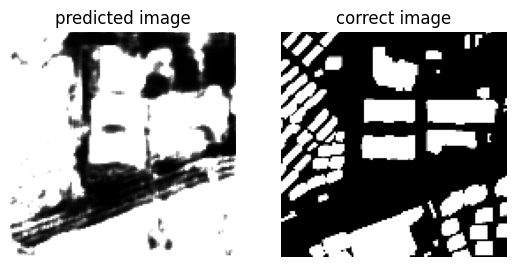

In [ ]:
import matplotlib.pyplot as plt

img1 = np.array(x_train[0])
res = model.predict(np.expand_dims(img1, axis = 0)) * 255 # predicted image , over 0.5 -> 255,
img2 = np.array(y_train[0])

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(cv2.cvtColor(res[0], cv2.COLOR_GRAY2BGR))
ax1.set_title("predicted image")
ax1.axis("off")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title("correct image")
ax2.axis("off")

plt.show()

def iou(x,y):
  x = x.flatten() #predict
  y = y.flatten() #answer
  tmp = [0 for _ in range (len(x))]
  s = [0 for _ in range (len(x))]
  for i in range(len(x)):
    if x[i] >= 0.5:
      x[i] = 255
    else:
      x[i] = 0
    if y[i] >= 0.5:
      y[i] = 255
    else:
      y[i] = 0
    if x[i] == 255 and y[i] == 255:
      tmp[i] = 255 # same
    elif x[i] == 255 and y[i] != 255:
      s[i] = 255
    elif x[i] != 255 and y[i] != 255:
      s[i] = 255
    else:
      s[i] = 255
  k = np.sum(s)
  d = np.sum(tmp)
  result = d / (k + d)
  return result

x = iou(res, img2)

In [ ]:
import requests
import json
from IPython.display import display, HTML
from datetime import datetime
import traceback

class DiscordNotifier:
    def __init__(self, webhook_url):
        self.webhook_url = webhook_url

    def send_message(self, content, title=None):
        """
        메시지를 디스코드로 전송합니다.

        Args:
            content: 전송할 내용
            title: 메시지 제목 (선택사항)
        """
        try:
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # 임베드 구성
            embed = {
                "description": str(content),
                "color": 3447003,  # 파란색
                "footer": {
                    "text": f"전송 시간: {current_time}"
                }
            }

            if title:
                embed["title"] = title

            payload = {
                "embeds": [embed]
            }

            # 웹훅으로 전송
            response = requests.post(
                self.webhook_url,
                data=json.dumps(payload),
                headers={"Content-Type": "application/json"}
            )

            if response.status_code == 204:
                display(HTML(f'<div style="color: green">✓ 메시지가 성공적으로 전송되었습니다.</div>'))
            else:
                display(HTML(f'<div style="color: red">⚠ 전송 실패: {response.status_code}</div>'))

        except Exception as e:
            error_msg = traceback.format_exc()
            display(HTML(f'<div style="color: red">⚠ 오류 발생: {error_msg}</div>'))

    def send_file(self, file_path, content=None):
        """
        파일을 디스코드로 전송합니다.

        Args:
            file_path: 전송할 파일 경로
            content: 추가 메시지 (선택사항)
        """
        try:
            payload = {}
            if content:
                payload["content"] = content

            files = {
                "file": open(file_path, "rb")
            }

            response = requests.post(
                self.webhook_url,
                data=payload,
                files=files
            )

            if response.status_code == 204:
                display(HTML(f'<div style="color: green">✓ 파일이 성공적으로 전송되었습니다.</div>'))
            else:
                display(HTML(f'<div style="color: red">⚠ 파일 전송 실패: {response.status_code}</div>'))

        except Exception as e:
            error_msg = traceback.format_exc()
            display(HTML(f'<div style="color: red">⚠ 오류 발생: {error_msg}</div>'))